In [1]:
using Graphs, GraphPlot, SimpleWeightedGraphs
using PyCall, DataFrames, CSV, Colors, Cairo, Compose, Geodesy, Statistics

nx = pyimport("networkx")
py"""
import networkx as nx
"""

## Загрузка данных, создание сетей

In [2]:
# Данные о регионах России
regions = DataFrame(CSV.File("data/regions-russia.csv")) 

# Выбор набора данных
# dataset = "birth-1989.csv" # с рождения по янв. 1989 г. (Перепись 1989 г., том 12, табл. 9)
# dataset = "birth-2002.csv" # с рождения по окт. 2002 г. (Перепись 2002 г., том 10, табл. 3)
# dataset = "1989-2002.csv"  # за период с янв. 1989 г. по окт. 2002 г. (Перепись 2002 г., том 10, табл. 2)
# dataset = "birth-2010.csv" # с рождения по окт. 2010 г. (Перепись 2010 г., том 8, табл. 3)
# dataset = "2009-2010.csv"  # за период с окт. 2009 г. по окт. 2010 г. (Перепись 2010 г., том 8, табл. 2)
# dataset = "VKcom-2015.csv" # Проект «Виртуальное население России», цифровые следы, ВКонтакте (янв-мар 2015 г.)
# dataset = "birth-2021.csv" # с рождения по 1 окт. 2023 г. (Перепись 2020-2021 гг., том 6, табл. 1)
dataset = "2015-2023.csv" # текущий учет с 2015 г. по 2023 г. (ЕМИСС, показатели № 43513 и 43514)


flows = DataFrame(CSV.File("data/" * dataset))
flows = filter(r -> r.origin != r.destination, flows)
regions = filter(r -> r.code in unique(vcat(flows[!, 1], flows[!, 2])), regions) # удаление регионов, которых нет в наборе
region_titles = Dict(regions.code[x] => regions.short_title[x] for x in 1:length(regions.code))
region_numbers = Dict(regions.code[x] => x for x in 1:length(regions.code))
        
flows = filter(r -> r.origin != 1111 && r.destination != 1111, flows)
flows = filter(r -> r.origin != 1171 && r.destination != 1171, flows)
flows = filter(r -> r.origin in regions.code && r.destination in regions.code, flows)

# Cоздание сети с помощью Graphs.jl
G = SimpleWeightedDiGraph(length(regions.code))
for r in eachrow(flows)
    add_edge!(G, region_numbers[r.origin], region_numbers[r.destination], r.migrants)
end

# Cоздание сети с помощью networkx
Gpy = nx.DiGraph()
for r in eachrow(flows)
    Gpy.add_edge(region_titles[r.origin], region_titles[r.destination], weight=r.migrants)
end

## Выделение хабов

In [3]:
# Метод Pagerank при damping factor = 1, вероятность перехода в случайный регион = 0
hubs = pagerank(G, 1.0, 1000, 1.0e-8) * 1000
sort(DataFrame(title = regions.short_title, pagerank = hubs), :pagerank, rev=true)[1:10,:]

Row,title,pagerank
,String31,Float64
1,Москва,129.188
2,Московская,116.713
3,СПб,68.5672
4,Краснодарский,48.4678
5,Ленинградская,38.6653
6,Ростовская,20.4435
7,ХМАО,20.027
8,Ставропольский,17.8645
9,Башкортостан,17.3975


## Определение кластеров (сообществ)

In [4]:
# Метод максимизации модулярности
py""" 
def gm_communities(G):
    return [list(x) for x in nx.community.greedy_modularity_communities(G, weight="weight")]
"""
clusters = py"gm_communities"(Gpy)

# Вывод состава клстеров
for i in 1:length(clusters)
    printstyled("Кластер " * string(i) *" (n = " * string(length(clusters[i])) * "): "; color = 20)
    println(string((clusters[i].* ", ")...)[1:end-3] * ".")
end

Кластер 1 (n = 21): Владимирская, Рязанская, Орловская, Московская, Липецкая, Воронежская, Тамбовская, Белгородская, Брянская, Пензенская, Смоленская, Тульская, Москва, Курская, Калужская, Нижегородская, Чувашская, Ивановская, Тверская, Саратовская, Мордовия.
Кластер 2 (n = 21): Амурская, Приморский, Хакасия, Новосибирская, Камчатский, Сахалинская, Забайкальский, Калининградская, Алтай, Алтайский, Якутия, Хабаровский, Бурятия, Томская, ЧАО, Магаданская, Кемеровская, Красноярский, Иркутская, Еврейская, Тыва.
Кластер 3 (n = 15): Севастополь, Ростовская, Крым, Северная Осетия, КЧР, Астраханская, Ингушетия, Адыгея, КБР, Дагестан, Ставропольский, Чеченская, Калмыкия, Волгоградская, Краснодарский.
Кластер 4 (n = 15): Тюменская, Оренбургская, ЯНАО, Курганская, Марий Эл, Ульяновская, Татарстан, Удмуртская, ХМАО, Омская, Башкортостан, Пермский, Челябинская, Свердловская, Самарская.
Кластер 5 (n = 13): Коми, Карелия, Псковская, Ярославская, Вологодская, Кировская, НАО, Архангельская, Ленинградск

## Расчет показателей сети

In [5]:
# Число узлов (размер сети)
nv(G) 
Gpy.number_of_nodes()

85

In [6]:
# Число ребер (связей)
ne(G)
Gpy.number_of_edges()

7138

In [7]:
# Плотность сети
density(G)
nx.density(Gpy)

0.9997198879551821

In [8]:
# Всего перемещений, млн
sum(flows.migrants)/1e06

18.200264

In [9]:
# Взаимность связей сети
(ne(G) - ne(SimpleGraph(G))) * 2 / ne(G)
nx.overall_reciprocity(Gpy)

0.9997198094704399

In [10]:
# Связность
is_strongly_connected(G)
is_weakly_connected(G)
nx.is_strongly_connected(Gpy)
nx.is_weakly_connected(Gpy)

true

In [11]:
# Cредний вес связи
mean(flows.migrants)
mean(G.weights)

2519.0676816609

In [12]:
# Средняя степень сети
ne(G) / nv(G) * 2
Gpy.number_of_edges() / Gpy.number_of_nodes() * 2

167.95294117647057

In [13]:
# Средняя сила сети
ne(G) / nv(G) * 2 * mean(flows.migrants)
Gpy.number_of_edges() / Gpy.number_of_nodes() * 2 * mean(flows.migrants)/1e03

428.24150588235295

In [14]:
# Взаимость сети
listofregions = unique(union(flows.origin, flows.destination))
freg = Dict(listofregions[x] => x for x in 1:length(listofregions))
AAA = zeros(Int, nv(G) ,nv(G))
for i in 1:length(flows.origin)
    AAA[freg[flows.origin[i]],freg[flows.destination[i]]] = flows.migrants[i]
end
WWW = zeros(Int, nv(G) ,nv(G) )
for i in 1:nv(G) 
    for j in 1:nv(G) 
        WWW[i,j] = minimum([AAA[i,j],AAA[j,i]])
    end
end
sum(WWW)/sum(AAA)

0.8405557194115426

In [15]:
# Средняя длина пути
nx.average_shortest_path_length(Gpy)

1.000280112044818

In [16]:
# Диаметр сети
nx.diameter(Gpy)

2

In [17]:
# Параметр гетерогенности
py""" 
def heterogeneity(G):
    degree_values = [v for k, v in G.degree()]
    dv2 = [x**2 for x in degree_values]
    return (sum(dv2) / len(dv2)) / ((sum(degree_values) / len(degree_values)) ** 2)
"""
py"heterogeneity"(Gpy)

1.000002423895377

In [18]:
# Коэффициент степенной ассортативности
assortativity(G)
nx.degree_assortativity_coefficient(Gpy)

-0.01663424121953302

In [19]:
# Коэффициент кластеризации
global_clustering_coefficient(G)

0.24843397697264358

## Крупнейшие потоки

In [20]:
top_flows = sort(flows, :migrants, rev=true)[1:25,:]

printstyled(dataset * ":"; bold = true)
println()
for i in 1:length(top_flows.origin)
    printstyled(string(i) * ". "; color = 20)
    print(region_titles[top_flows.origin[i]])
    printstyled(" → "; color = 20)
    print(region_titles[top_flows.destination[i]])
    printstyled(" (" * string(top_flows.migrants[i]) * ")"; color = :red)
    println()
end

2015-2023.csv:
1. Московская → Москва (639842)
2. Москва → Московская (574821)
3. СПб → Ленинградская (283611)
4. Ленинградская → СПб (219777)
5. Ростовская → Краснодарский (74718)
6. ХМАО → Тюменская (71587)
7. Краснодарский → Ростовская (67182)
8. Краснодарский → Москва (65395)
9. ХМАО → Башкортостан (58313)
10. Башкортостан → ХМАО (57529)
11. Краснодарский → Адыгея (54333)
12. Москва → Краснодарский (53898)
13. Тульская → Московская (51294)
14. Хакасия → Красноярский (51059)
15. Ростовская → Московская (50756)
16. Владимирская → Московская (49982)
17. Саратовская → Московская (49580)
18. Краснодарский → Московская (49026)
19. Красноярский → Хакасия (48421)
20. Тульская → Москва (48250)
21. Ростовская → Москва (47862)
22. Ставропольский → Краснодарский (47313)
23. Тверская → Московская (47283)
24. Башкортостан → Челябинская (46855)
25. ЯНАО → Тюменская (46479)


## Группировка потоков для хордовых диаграмм

In [21]:
region_chord = Dict(regions.code[x] => regions.chord[x] for x in 1:length(regions.code))

# Группировка по федеральным округам и важнейшим регионам
chord = zeros(Int, 13,13)
for r in eachrow(flows)
        chord[region_chord[r.origin], region_chord[r.destination]] += r.migrants
end
chord

# В процентах от общего числа перемещений
chord_norm = map(x -> x / sum(chord) * 100 / 2, chord)
chord_norm

13×13 Matrix{Float64}:
 0.0        1.57916    1.03121    …  0.14813    0.206511   0.113614
 1.75778    0.0        0.844416      0.0955618  0.130388   0.0838477
 1.32382    1.40816    1.27277       0.163899   0.129822   0.14713
 0.126105   0.0705182  0.237376      0.127951   0.151031   0.124476
 0.0244227  0.0241343  0.0831719     0.0312386  0.0415571  0.0308182
 0.178585   0.179473   0.42965    …  0.0706336  0.0785456  0.0593975
 0.179654   0.134685   0.135023      0.163976   0.175561   0.127668
 0.403906   0.393698   0.230387      0.134602   0.0932624  0.0978502
 0.387717   0.289768   0.145424      0.221414   0.0901223  0.0662957
 0.956862   0.9393     0.416947      0.92869    0.198091   0.162355
 0.2307     0.174682   0.204928   …  1.69473    0.323091   0.0871224
 0.333534   0.272219   0.194459      0.417324   2.1505     0.459867
 0.181964   0.164308   0.216458      0.103059   0.535462   1.03

## Визуализация сетей

In [22]:
# Массив всех перемещений по узлам
moves = zeros(Int, length(regions.code),4)
for r in eachrow(flows)
    moves[region_numbers[r.origin], 1] += r.migrants
    moves[region_numbers[r.destination], 2] += r.migrants
end

for i in 1:length(regions.code)
    moves[i, 3] = maximum(filter(r -> r.origin == regions.code[i], flows).migrants)
    moves[i, 4] = maximum(filter(r -> r.destination == regions.code[i], flows).migrants)
end

# Оставляем только важнейшие потоки
ε1 = 0.1
ε2 = 0.05
flows_vis = filter(r ->  r.migrants >= moves[region_numbers[r.origin], 1] * ε1 || 
    r.migrants >= moves[region_numbers[r.destination],2] * ε2||
    r.migrants == moves[region_numbers[r.origin],3] ||
    r.migrants == moves[region_numbers[r.destination],4], flows)

# Создание сети для визуализации
Gvis = SimpleDiGraph(length(regions.code))
for r in eachrow(flows_vis)
    add_edge!(Gvis, region_numbers[r.origin], region_numbers[r.destination])
end
Gvis

{85, 455} directed simple Int64 graph

In [23]:
nodelabel = regions.short_title              # вектор заголовков узлов
# nodelabel = regions.soviet_short_title     # названия регионов 1989 г.  
nodesize = (moves[:,1] .+ moves[:,2]).^(1/2) # вектор размеров узлов
nodelabelsize = nodesize.^(1/8)              # вектор размеров заголовков

# Вектор толщины стрелок
edgelinewidth = []
for e in edges(Gvis)
    push!(edgelinewidth, filter(r -> region_numbers[r.origin] == src(e) && 
            region_numbers[r.destination] == dst(e), flows_vis)[!, 3]...)
end
edgelinewidth = edgelinewidth.^(1/1.85)

# Вычисление кластеров
py""" 
def gm_communities(G):
    return [list(x) for x in nx.community.greedy_modularity_communities(G, weight="weight")]
"""
clusters = py"gm_communities"(Gpy)

clusterdict = Dict()
region_color_numbers = Dict(regions.short_title[x] => x for x in 1:length(regions.code))
# Вывод состава клстеров
for i in 1:length(clusters)
    for j in 1:length(clusters[i])
        clusterdict[region_color_numbers[clusters[i][j]]] = i
    end
end

# Словарь цветов по кластерам
NodeCOlorDict = Dict(
    1 => colorant"#52a1ff", 
    2 => colorant"#E09FFF", 
    3 => colorant"#ff8987", 
    4 => colorant"#facc43", 
    5 => colorant"#88df55", 
    6 => colorant"#ff8987",
)

# Вектор цветов узлов
nodefillc = RGBA[]
for i in 1:length(regions.code)
    push!(nodefillc, NodeCOlorDict[clusterdict[i]])
end

# Вектор цветов стрелок
edgestrokecc = RGBA[]
color = 0.
for e in edges(Gvis)
    color = nodefillc[src(e)]
    push!(edgestrokecc,  color)
end

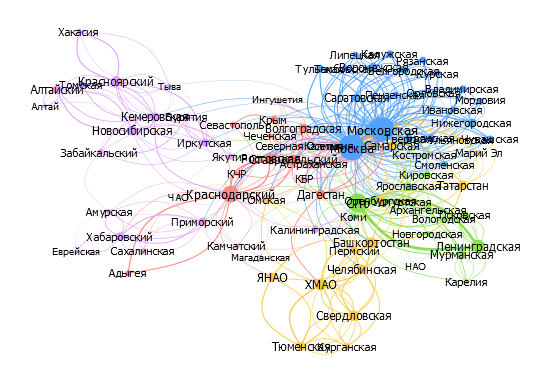

In [24]:
# Настройка макета
layout = (args...) -> spring_layout(args...; C = 5.0, MAXITER = 1000, INITTEMP = 2.0)

# Визуализация
migrplot = gplot(Gvis, linetype="curve",
                 nodelabel = nodelabel, 
                 nodelabelsize = nodelabelsize,
                 nodesize = nodesize, 
                 NODESIZE = 0.060,
                 NODELABELSIZE = 3.5,
                 edgestrokec = edgestrokecc, 
                 nodefillc = nodefillc, 
                 nodestrokec = RGB(0.35, 0.35, 0.45), 
                 nodestrokelw = 0.0,
                 edgelinewidth = edgelinewidth, 
                 EDGELINEWIDTH = 1.15,
                 arrowlengthfrac = 0.01,
                 arrowangleoffset = 15.0/180.0*π,
                 layout = layout)

# Отрисовка
Compose.draw(SVG("graph.svg", 25cm, 25cm), migrplot)
migrplot

## КИМС

In [25]:
kims = flows
region_popul = Dict(regions.code[x] => regions.popul2021[x] for x in 1:length(regions.code))
region_number = Dict(regions.code[x] => x for x in 1:length(regions.code))
kims.pop_origin = [region_popul[x] for x in kims.origin]
kims.pop_destination = [region_popul[x] for x in kims.destination]
kims

outsum = zeros(Int, length(regions.code))
for r in eachrow(kims)
        outsum[region_number[r.origin]] += r.migrants
end
kims.outsum = [outsum[region_number[x]] for x in kims.origin]

kims.origin_t = [region_titles[x] for x in kims.origin]
kims.dest_t = [region_titles[x] for x in kims.destination]

borders = DataFrame(CSV.File("data/borders-russia.csv"))
kims.border = zeros(Int, length(kims.origin))
for r in eachrow(kims)
    b = filter(x -> x.origin == r.origin && x.destination == r.destination, borders)
    if length(b.value) > 0
        r.border = b.value[1]
    end
end

region_lat = Dict(regions.code[x] => regions.lat[x] for x in 1:length(regions.code))
region_lon = Dict(regions.code[x] => regions.lon[x] for x in 1:length(regions.code))

dist = []
for x in eachrow(kims)
    push!(dist, euclidean_distance(LLA(region_lat[x.origin], region_lon[x.origin], 0.0), 
            LLA(region_lat[x.destination], region_lon[x.destination], 0.0)) / 1000)
end
kims.dist = dist

total_population = sum(values(region_popul))
kims.kims = zeros(length(kims.origin))
for r in eachrow(kims)
       r.kims = (r.migrants * (total_population - r.pop_origin) / 
           (r.pop_origin * r.pop_destination)) / (r.outsum / r.pop_origin)
end
sort!(filter(r -> r.border == 0, kims), :kims, rev = true)[1:10,7:end]
sort!(filter(r -> r.border == 1, kims), :kims, rev = false)[1:10,7:end]

Row,origin_t,dest_t,border,dist,kims
,String31,String31,Int64,Any,Float64
1,ХМАО,Красноярский,1,1219.72,0.251913
2,ЯНАО,Красноярский,1,1313.54,0.2601
3,Коми,Свердловская,1,773.976,0.32112
4,ХМАО,Коми,1,992.519,0.402257
5,Коми,ХМАО,1,992.519,0.5375
6,Красноярский,ХМАО,1,1219.72,0.54407
7,Тверская,Вологодская,1,365.864,0.544886
8,Рязанская,Нижегородская,1,308.652,0.582353
9,Саратовская,Оренбургская,1,641.402,0.632213
